# Experiment 4: General-Sum Games & Social Welfare

**Objective**: Compare all 4 CFR variants on **general-sum games**, where players' interests are not strictly opposed.

**Context**: In zero-sum games, Nash Equilibrium is the undisputed solution concept. In general-sum games (like the Prisoner's Dilemma), Nash Equilibria can be suboptimal for the group (low Social Welfare). We want to see how different CFR variants perform in these settings.

**Algorithms Compared**:
1. **MCCFR (Vanilla)** - Monte Carlo sampling at chance nodes
2. **MCCFR+** - Monte Carlo with regret flooring + linear averaging
3. **Full-Width CFR (Vanilla)** - Textbook algorithm, full expectation at chance nodes
4. **Full-Width CFR+** - Textbook CFR+ with regret flooring + linear averaging

**Games**:
1. **3-Player Goofspiel**: A competitive card game (constant-sum-ish) to test multiplayer convergence.
2. **3-Player Prisoner's Dilemma**: A classic general-sum game to test cooperation vs. defection.

In [1]:
%matplotlib inline
import pyspiel
import numpy as np
import matplotlib.pyplot as plt
import time
from solvers import CFRSolver, CFRPlusSolver, FullWidthCFRSolver, FullWidthCFRPlusSolver
from open_spiel.python.algorithms import exploitability

print("Ready for General-Sum analysis!")

Optional module pokerkit_wrapper was not importable: No module named 'pokerkit'
Ready for General-Sum analysis!


Loading 3-player Goofspiel (Turn-based)...
Training MCCFR (Vanilla)...
Iteration 2000/2000 - NashConv: 0.003135
Training MCCFR+...
Iteration 2000/2000 - NashConv: 0.061681
Training Full-Width CFR (Vanilla)...
Iteration 2000/2000 - NashConv: 0.000439
Training Full-Width CFR+...
Iteration 2000/2000 - NashConv: 0.000000


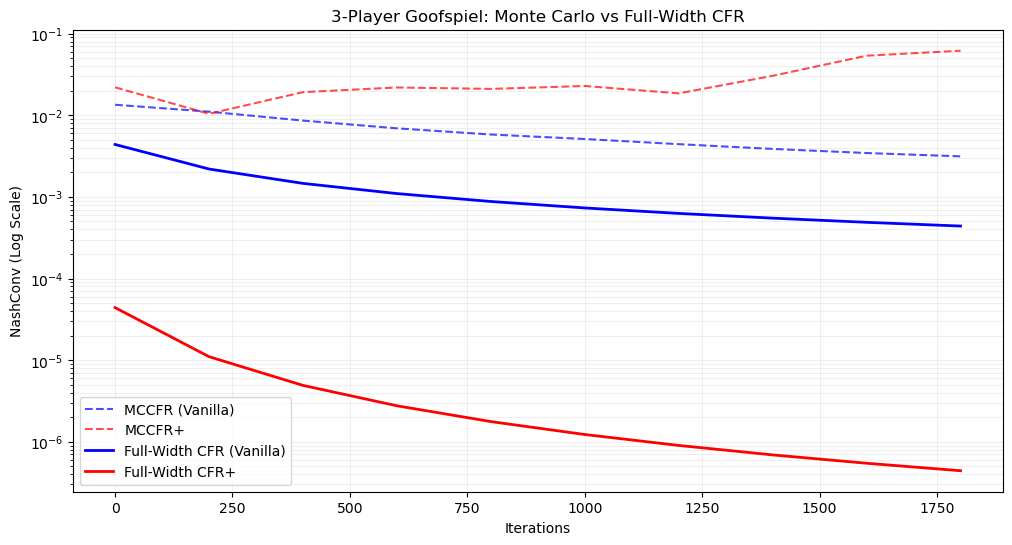


=== 3-Player Goofspiel Results ===
Algorithm                 Final NashConv     Time (s)  
-------------------------------------------------------
MCCFR (Vanilla)           0.003135           20.06     
MCCFR+                    0.061681           18.53     
Full-Width CFR            0.000439           96.54     
Full-Width CFR+           0.000000           98.30     


In [2]:
# Part 1: 3-Player Goofspiel - Compare all 4 variants
print("Loading 3-player Goofspiel (Turn-based)...")
game_string = "turn_based_simultaneous_game(game=goofspiel(players=3,num_cards=3,imp_info=True))"
game = pyspiel.load_game(game_string)

iterations = 2000
log_every = 200

# Monte Carlo variants
print("Training MCCFR (Vanilla)...")
start = time.time()
solver_mc_vanilla = CFRSolver(game)
history_mc_vanilla = solver_mc_vanilla.train(iterations, log_every=log_every)
time_mc_vanilla = time.time() - start

print("Training MCCFR+...")
start = time.time()
solver_mc_plus = CFRPlusSolver(game)
history_mc_plus = solver_mc_plus.train(iterations, log_every=log_every)
time_mc_plus = time.time() - start

# Full-width variants
print("Training Full-Width CFR (Vanilla)...")
start = time.time()
solver_fw_vanilla = FullWidthCFRSolver(game)
history_fw_vanilla = solver_fw_vanilla.train(iterations, log_every=log_every)
time_fw_vanilla = time.time() - start

print("Training Full-Width CFR+...")
start = time.time()
solver_fw_plus = FullWidthCFRPlusSolver(game)
history_fw_plus = solver_fw_plus.train(iterations, log_every=log_every)
time_fw_plus = time.time() - start

# Plotting
x_axis = np.arange(len(history_mc_vanilla['nash_conv'])) * log_every

plt.figure(figsize=(12, 6))

# Monte Carlo variants (dashed lines)
plt.plot(x_axis, history_mc_vanilla['nash_conv'], 'b--', label="MCCFR (Vanilla)", alpha=0.7)
plt.plot(x_axis, history_mc_plus['nash_conv'], 'r--', label="MCCFR+", alpha=0.7)

# Full-width variants (solid lines)
plt.plot(x_axis, history_fw_vanilla['nash_conv'], 'b-', label="Full-Width CFR (Vanilla)", linewidth=2)
plt.plot(x_axis, history_fw_plus['nash_conv'], 'r-', label="Full-Width CFR+", linewidth=2)

plt.yscale("log")
plt.title("3-Player Goofspiel: Monte Carlo vs Full-Width CFR")
plt.xlabel("Iterations")
plt.ylabel("NashConv (Log Scale)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

print("\n=== 3-Player Goofspiel Results ===")
print(f"{'Algorithm':<25} {'Final NashConv':<18} {'Time (s)':<10}")
print("-" * 55)
print(f"{'MCCFR (Vanilla)':<25} {history_mc_vanilla['nash_conv'][-1]:<18.6f} {time_mc_vanilla:<10.2f}")
print(f"{'MCCFR+':<25} {history_mc_plus['nash_conv'][-1]:<18.6f} {time_mc_plus:<10.2f}")
print(f"{'Full-Width CFR':<25} {history_fw_vanilla['nash_conv'][-1]:<18.6f} {time_fw_vanilla:<10.2f}")
print(f"{'Full-Width CFR+':<25} {history_fw_plus['nash_conv'][-1]:<18.6f} {time_fw_plus:<10.2f}")


Creating 3-Player Prisoner's Dilemma...
Training MCCFR (Vanilla)...
Iteration 1000/2000 - NashConv: 0.001501
Iteration 2000/2000 - NashConv: 0.000750
Training MCCFR+...
Iteration 1000/2000 - NashConv: 0.000003
Iteration 2000/2000 - NashConv: 0.000001
Training Full-Width CFR (Vanilla)...
Iteration 1000/2000 - NashConv: 0.001501
Iteration 2000/2000 - NashConv: 0.000750
Training Full-Width CFR+...
Iteration 1000/2000 - NashConv: 0.000003
Iteration 2000/2000 - NashConv: 0.000001


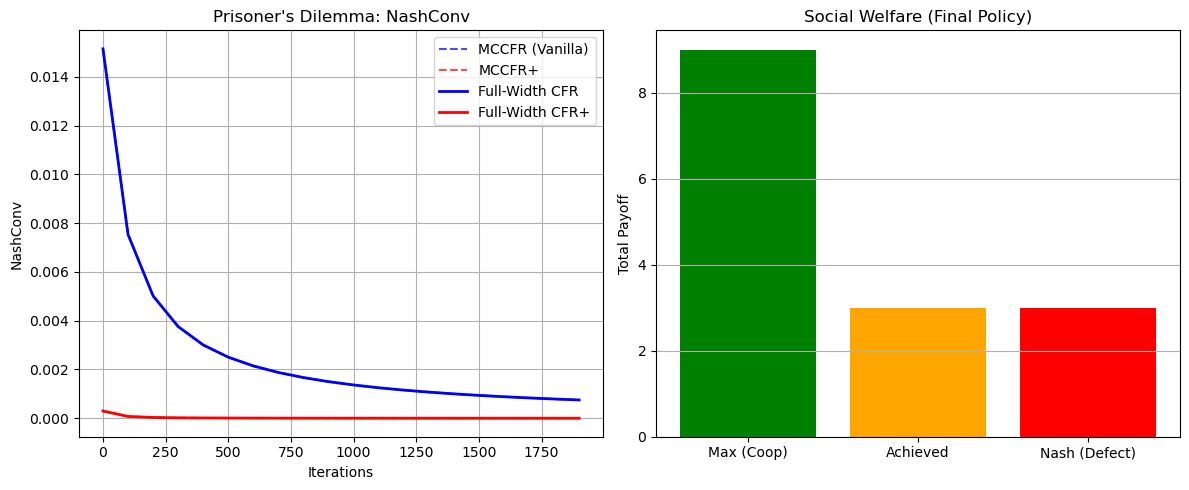


=== Prisoner's Dilemma Results ===
Algorithm                 Final NashConv    
---------------------------------------------
MCCFR (Vanilla)           0.000750          
MCCFR+                    0.000001          
Full-Width CFR            0.000750          
Full-Width CFR+           0.000001          

Final Social Welfare: 3.00 (Max=9, Nash=3)


In [3]:
# Part 2: 3-Player Prisoner's Dilemma - Compare all 4 variants
print("\nCreating 3-Player Prisoner's Dilemma...")

# Define payoff tensors
p0_payoffs = np.zeros((2, 2, 2))
p1_payoffs = np.zeros((2, 2, 2))
p2_payoffs = np.zeros((2, 2, 2))

# C=0, D=1
for a0 in range(2):
    for a1 in range(2):
        for a2 in range(2):
            actions = [a0, a1, a2]
            num_defectors = sum(actions)
            
            if num_defectors == 0:  # CCC
                rewards = [3, 3, 3]
            elif num_defectors == 1:
                rewards = [5 if a == 1 else 0 for a in actions]
            elif num_defectors == 2:
                rewards = [2 if a == 1 else 0 for a in actions]
            else:  # DDD
                rewards = [1, 1, 1]
            
            p0_payoffs[a0, a1, a2] = rewards[0]
            p1_payoffs[a0, a1, a2] = rewards[1]
            p2_payoffs[a0, a1, a2] = rewards[2]

tensor_game = pyspiel.create_tensor_game([p0_payoffs, p1_payoffs, p2_payoffs])
game = pyspiel.convert_to_turn_based(tensor_game)

iterations = 2000
log_every = 100

# Train all 4 solvers
print("Training MCCFR (Vanilla)...")
solver_mc_vanilla = CFRSolver(game)
history_mc_vanilla = solver_mc_vanilla.train(iterations, log_every=log_every)

print("Training MCCFR+...")
solver_mc_plus = CFRPlusSolver(game)
history_mc_plus = solver_mc_plus.train(iterations, log_every=log_every)

print("Training Full-Width CFR (Vanilla)...")
solver_fw_vanilla = FullWidthCFRSolver(game)
history_fw_vanilla = solver_fw_vanilla.train(iterations, log_every=log_every)

print("Training Full-Width CFR+...")
solver_fw_plus = FullWidthCFRPlusSolver(game)
history_fw_plus = solver_fw_plus.train(iterations, log_every=log_every)

# Plot NashConv for all 4
x_axis = np.arange(len(history_mc_vanilla['nash_conv'])) * log_every

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_axis, history_mc_vanilla['nash_conv'], 'b--', label="MCCFR (Vanilla)", alpha=0.7)
plt.plot(x_axis, history_mc_plus['nash_conv'], 'r--', label="MCCFR+", alpha=0.7)
plt.plot(x_axis, history_fw_vanilla['nash_conv'], 'b-', label="Full-Width CFR", linewidth=2)
plt.plot(x_axis, history_fw_plus['nash_conv'], 'r-', label="Full-Width CFR+", linewidth=2)
plt.title("Prisoner's Dilemma: NashConv")
plt.xlabel("Iterations")
plt.ylabel("NashConv")
plt.legend()
plt.grid(True)

# Calculate welfare for best solver (Full-Width CFR+) to show cooperation result
plt.subplot(1, 2, 2)
policy = solver_fw_plus.get_policy()
welfare_history = []

# Recalculate welfare over training (approximate by sampling)
for _ in range(100):
    state = game.new_initial_state()
    while not state.is_terminal():
        if state.is_chance_node():
            action = np.random.choice([o[0] for o in state.chance_outcomes()], p=[o[1] for o in state.chance_outcomes()])
        else:
            p_probs = policy.action_probabilities(state)
            actions = list(p_probs.keys())
            probs = list(p_probs.values())
            action = np.random.choice(actions, p=probs)
        state.apply_action(action)
    welfare_history.append(sum(state.returns()))

avg_welfare = np.mean(welfare_history)
plt.bar(['Max (Coop)', 'Achieved', 'Nash (Defect)'], [9, avg_welfare, 3], color=['green', 'orange', 'red'])
plt.title("Social Welfare (Final Policy)")
plt.ylabel("Total Payoff")
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

print("\n=== Prisoner's Dilemma Results ===")
print(f"{'Algorithm':<25} {'Final NashConv':<18}")
print("-" * 45)
print(f"{'MCCFR (Vanilla)':<25} {history_mc_vanilla['nash_conv'][-1]:<18.6f}")
print(f"{'MCCFR+':<25} {history_mc_plus['nash_conv'][-1]:<18.6f}")
print(f"{'Full-Width CFR':<25} {history_fw_vanilla['nash_conv'][-1]:<18.6f}")
print(f"{'Full-Width CFR+':<25} {history_fw_plus['nash_conv'][-1]:<18.6f}")
print(f"\nFinal Social Welfare: {avg_welfare:.2f} (Max=9, Nash=3)")

## Result Interpretation

### Goofspiel (3-Player)
- Compare the 4 algorithms on this constant-sum multiplayer game
- Does CFR+ still underperform vanilla in this 3-player setting (like in 3-player Kuhn)?
- How does the simultaneous-move structure affect convergence?

### Prisoner's Dilemma (3-Player)
- All algorithms should converge to NashConv ≈ 0 (the game has a unique Nash)
- Social welfare should converge to ~3 (all defect), not 9 (all cooperate)
- This confirms CFR finds "rational but selfish" equilibria
- The interesting question: do the 4 variants converge at different rates?

### Key Questions:
1. Does the CFR+ vs Vanilla pattern from poker games hold in general-sum games?
2. Does full-width still dominate Monte Carlo in these smaller state spaces?
3. Are there any surprising differences in convergence behavior?